# GAN with Keras

### Load the data

In [36]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

In [40]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

### Defining GAN's functions

In [41]:
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

In [42]:
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [43]:
def train(epochs, batch_size=128, save_interval=50, n_jobs=-1):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        g_loss = combined.train_on_batch(noise, valid_y)
        
        if epoch % 100 == 0:

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [44]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

### Build and train the model

In [45]:
optimizer = Adam(0.0002, 0.5)

In [46]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [47]:
#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 1024)             

In [48]:
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

In [49]:
discriminator.trainable = False 

In [50]:
valid = discriminator(img) 

In [51]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [52]:
#save model every 200 epochs
train(epochs=100, batch_size=32, save_interval=100)

0 [D loss: 0.654639, acc.: 75.00%] [G loss: 0.781075]


In [79]:
generator.save('DATA/generator_model_10000.h5',include_optimizer=False)  #Test the model on GAN4_predict...

# Generate Mnist

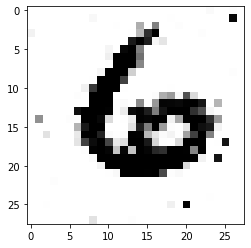

In [101]:
# load model
model = load_model('DATA/generator_model_10000.h5')

#To create same image, suppy same vector each time
#vector = asarray([[0. for _ in range(100)]])

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

# Compare GAN's learning

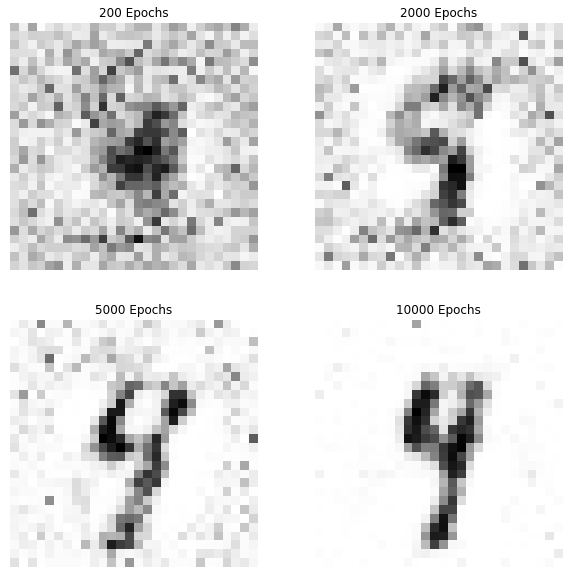

In [111]:
fig = plt.figure(figsize=(10,10))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.axis('off')

ax1 = fig.add_subplot(221)
model = load_model('DATA/generator_model_200.h5')
vector = asarray([[0. for _ in range(100)]])
X = model.predict(vector)
ax1.imshow(X[0, :, :, 0], cmap='gray_r')
plt.axis('off')

ax2 = fig.add_subplot(222)
model = load_model('DATA/generator_model_2000.h5')
vector = asarray([[0. for _ in range(100)]])
X = model.predict(vector)
ax2.imshow(X[0, :, :, 0], cmap='gray_r')
plt.axis('off')

ax3 = fig.add_subplot(223)
model = load_model('DATA/generator_model_5000.h5')
vector = asarray([[0. for _ in range(100)]])
X = model.predict(vector)
ax3.imshow(X[0, :, :, 0], cmap='gray_r')
plt.axis('off')

ax4 = fig.add_subplot(224)
model = load_model('DATA/generator_model_10000.h5')
vector = asarray([[0. for _ in range(100)]])
X = model.predict(vector)
ax4.imshow(X[0, :, :, 0], cmap='gray_r')
plt.axis('off')

ax1.set_title('200 Epochs')
ax2.set_title('2000 Epochs')
ax3.set_title('5000 Epochs')
ax4.set_title('10000 Epochs')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.axis('off')
plt.show()